***Web Scrape data from Reddit***

In [2]:
import praw
import pandas as pd
import time

# 🔐 Reddit API setup
reddit = praw.Reddit(
    client_id="F8V0A9qbXrt1s5xf5ZijFQ",
    client_secret="UiUOr873GXBrtXy4Zrs_ka-8JbdxFg",
    user_agent="mitali"
)

# 🎯 List of subreddits to search in
subreddits = ["Supplements", "Nutrition", "Vitamins"]

# 🔍 Search terms (shortened brand/product names)
search_terms = [
    "thorne", "one a day", "megafood", "pure encapsulations", "klean athlete",
    "ritual", "garden of life", "mykind", "smartypants", "olly", "centrum",
    "nature made", "renzo", "viridian", "purolabs", "puro", "vitafusion", "weightworld"
]

# 📦 Master list to collect results
all_rows = []

# 🔁 Loop through subreddits and search terms
for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    print(f"\n📂 Searching in r/{sub}")

    for keyword in search_terms:
        print(f"🔍 Searching for: '{keyword}'")
        try:
            top_posts = list(subreddit.search(query=keyword, sort="new", time_filter="all", limit=1000))
            print(f"→ {len(top_posts)} posts found")

            for post in top_posts:
                try:
                    post.comments.replace_more(limit=0)
                    comments = post.comments.list()

                    for comment in comments:
                        comment_row = {
                            'Search_Term': keyword,
                            'Subreddit': sub,
                            'Title': post.title,
                            'Post_ID': post.id,
                            'Author': str(post.author),
                            'URL': post.url,
                            'Post_Score': post.score,
                            'Num_Comments': post.num_comments,
                            'Created_UTC': post.created_utc,
                            'Comment': comment.body,
                            'Comment_Author': str(comment.author),
                            'Comment_Score': comment.score
                        }
                        all_rows.append(comment_row)

                    # Add original post row
                    post_row = {
                        'Search_Term': keyword,
                        'Subreddit': sub,
                        'Title': post.title,
                        'Post_ID': post.id,
                        'Author': str(post.author),
                        'URL': post.url,
                        'Post_Score': post.score,
                        'Num_Comments': post.num_comments,
                        'Created_UTC': post.created_utc,
                        'Comment': None,
                        'Comment_Author': None,
                        'Comment_Score': None
                    }
                    all_rows.append(post_row)

                except Exception as e:
                    print(f"⚠️ Error processing post {post.id}: {e}")

                time.sleep(1)

        except Exception as e:
            print(f"❌ Error with keyword '{keyword}' in r/{sub}: {e}")

        time.sleep(2)

# 💾 Save final dataset
df_multi_subs = pd.DataFrame(all_rows)
df_multi_subs.to_csv("reddit_multivitamins_multi_subreddits.csv", index=False)
print(f"\n✅ Done! Total rows: {len(df_multi_subs)} saved to 'reddit_multivitamins_multi_subreddits.csv'")



📂 Searching in r/Supplements
🔍 Searching for: 'thorne'
→ 239 posts found
🔍 Searching for: 'one a day'
→ 246 posts found
🔍 Searching for: 'megafood'
→ 38 posts found
🔍 Searching for: 'pure encapsulations'
→ 234 posts found
🔍 Searching for: 'klean athlete'
→ 1 posts found
🔍 Searching for: 'ritual'
→ 56 posts found
🔍 Searching for: 'garden of life'
→ 218 posts found
🔍 Searching for: 'mykind'
→ 30 posts found
🔍 Searching for: 'smartypants'
→ 6 posts found
🔍 Searching for: 'olly'
→ 73 posts found
🔍 Searching for: 'centrum'
→ 177 posts found
🔍 Searching for: 'nature made'
→ 237 posts found
🔍 Searching for: 'renzo'
→ 0 posts found
🔍 Searching for: 'viridian'
→ 4 posts found
🔍 Searching for: 'purolabs'
→ 0 posts found
🔍 Searching for: 'puro'
→ 0 posts found
🔍 Searching for: 'vitafusion'
→ 33 posts found
🔍 Searching for: 'weightworld'
→ 19 posts found

📂 Searching in r/Nutrition
🔍 Searching for: 'thorne'
→ 14 posts found
🔍 Searching for: 'one a day'
→ 239 posts found
🔍 Searching for: 'megafood

 **NLP Preprocessing of Reddit Supplement Discussions**

 **Introduction**

Preprocessing text data is a foundational step in any Natural Language Processing (NLP) project, ensuring that unstructured data is transformed into a clean, consistent format suitable for analysis. 

In this notebook, we focus on preparing Reddit comments from supplement-focused subreddits such as `r/Supplements`, `r/Nutrition`, and `r/Vitamins`. These discussions are often informal, messy, and filled with domain-specific references. Therefore, a robust preprocessing pipeline is essential to extract meaningful patterns, sentiments, and user intent.

This project aims to understand how users talk about multivitamins, why they take them (e.g., for sleep, stress, fatigue), and how they describe their outcomes, all using real-world, community-driven conversations.

This preprocessing step involves several key tasks to clean and transform the text data into a usable format.

---

 **Objectives**

**1. Load and Inspect Reddit Data**  
&nbsp;&nbsp;&nbsp;&nbsp;• Import Reddit comments from wellness-related subreddits  
&nbsp;&nbsp;&nbsp;&nbsp;• Explore structure and content  
&nbsp;&nbsp;&nbsp;&nbsp;• Identify missing data, links, or formatting issues

**2. Clean the Text Data**  
&nbsp;&nbsp;&nbsp;&nbsp;• Remove HTML tags  
&nbsp;&nbsp;&nbsp;&nbsp;• Replace URLs with `[LINK]`  
&nbsp;&nbsp;&nbsp;&nbsp;• Standardize casing and whitespace  
&nbsp;&nbsp;&nbsp;&nbsp;• Preserve supplement brand names using custom replacements

**3. Preprocess Text with SpaCy**  
&nbsp;&nbsp;&nbsp;&nbsp;• Tokenize, remove stopwords, lemmatize  
&nbsp;&nbsp;&nbsp;&nbsp;• Create three views: `tokens-dirty`, `tokens`, and `lemmas`  
&nbsp;&nbsp;&nbsp;&nbsp;• Apply a supplement whitelist to avoid token breakage

**4. Validate and Export**  
&nbsp;&nbsp;&nbsp;&nbsp;• Test terms like `5-HTP`, `omega 3`, `B12`  
&nbsp;&nbsp;&nbsp;&nbsp;• Export preprocessed CSV for modeling and analysis

---

##  **Outcome**

By the end of this notebook, we will have a clean and structured dataset of Reddit supplement discussions, implementation of sentiment analysis tools.



In [71]:
## import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [24]:

# Load the Reddit multivitamin dataset
df = pd.read_csv("reddit_multivitamins_multi_data.csv")

# Preview
print(df.shape)
df.head(10)


(38436, 12)


,Search_Term,Subreddit,Title,Post_ID,Author,URL,Post_Score,Num_Comments,Created_UTC,Comment,Comment_Author,Comment_Score
0,thorne,Supplements,Ratey daily stack,1jx4cds,Flurb789,https://i.redd.it/114kjl6goaue1.jpeg,3,7,1.744416e+09,Rules of r/supplements \n\n1.\nDo Not Suggest Prescription Drugs\nPosts & Comments\nReported as: Do Not Suggest Prescription Drugs\nPrescription drugs are not Supplements; do not recommend prescription medication. \nSensible/Suggest talking to DR...,AutoModerator,1.0
1,thorne,Supplements,Ratey daily stack,1jx4cds,Flurb789,https://i.redd.it/114kjl6goaue1.jpeg,3,7,1.744416e+09,"9.0\n\nThat Thorne has K2-MK4, which is good, but some MK7 would also fit into your stack nicely .\n\nOther than that, it's a great stack.",I-Lyke-Shicken,1.0
2,thorne,Supplements,Ratey daily stack,1jx4cds,Flurb789,https://i.redd.it/114kjl6goaue1.jpeg,3,7,1.744416e+09,I'll check out EFA. Was thinking of adding something to the sleep side maybe... Ashwaganda or glycine?,Flurb789,1.0
3,thorne,Supplements,Ratey daily stack,1jx4cds,Flurb789,https://i.redd.it/114kjl6goaue1.jpeg,3,7,1.744416e+09,"So, tell me more about EFA. Not covered with the Omegavia? Sorry, just learning",Flurb789,1.0
4,thorne,Supplements,Ratey daily stack,1jx4cds,Flurb789,https://i.redd.it/114kjl6goaue1.jpeg,3,7,1.744416e+09,"Sorry, that was my mistake. I couldn't see it good on my phone but see it now on my laptop. You have an EFA supplement.\n\nYou already have a glycine supplement with the magnesium glycinate. That is magnesium + glycine. Taking it before bed shoul...",I-Lyke-Shicken,1.0
5,thorne,Supplements,Ratey daily stack,1jx4cds,Flurb789,https://i.redd.it/114kjl6goaue1.jpeg,3,7,1.744416e+09,Thanks! I did not know that,Flurb789,1.0
6,thorne,Supplements,Ratey daily stack,1jx4cds,Flurb789,https://i.redd.it/114kjl6goaue1.jpeg,3,7,1.744416e+09,NaN,NaN,NaN
7,thorne,Supplements,I've heard both NOW and Thorne are both reputable brands but why is there such a huge price difference?,1jww4zq,MessyNematoda,https://www.reddit.com/r/Supplements/comments/1jww4zq/ive_heard_both_now_and_thorne_are_both_reputable/,0,3,1.744394e+09,Rules of r/supplements \n\n1.\nDo Not Suggest Prescription Drugs\nPosts & Comments\nReported as: Do Not Suggest Prescription Drugs\nPrescription drugs are not Supplements; do not recommend prescription medication. \nSensible/Suggest talking to DR...,AutoModerator,1.0
8,thorne,Supplements,I've heard both NOW and Thorne are both reputable brands but why is there such a huge price difference?,1jww4zq,MessyNematoda,https://www.reddit.com/r/Supplements/comments/1jww4zq/ive_heard_both_now_and_thorne_are_both_reputable/,0,3,1.744394e+09,"Genuinely, I feel like Thorne is about aesthetic. Maybe I’m wrong. They may also 3rd-party test there supplements but I’m not privy to it. NOW is a perfectly good option with a good track record for a company as large as such.",psychoticWine,5.0
9,thorne,Supplements,I've heard both NOW and Thorne are both reputable brands but why is there such a huge price difference?,1jww4zq,MessyNematoda,https://www.reddit.com/r/Supplements/comments/1jww4zq/ive_heard_both_now_and_thorne_are_both_reputable/,0,3,1.744394e+09,Id agree simply by the people they have do advertisements for them.,myshadowsvoice,1.0


In [25]:
#Check for null values
df.isna().sum()

Search_Term          0
Subreddit            0
Title                0
Post_ID              0
Author               0
URL                  0
Post_Score           0
Num_Comments         0
Created_UTC          0
Comment           2331
Comment_Author    5381
Comment_Score     2331
dtype: int64

In [26]:
# Drop rows where Comment is null
df = df[df['Comment'].notna()].reset_index(drop=True)

# Confirm change
print(f"✅ Remaining rows after drop: {len(df)}")


✅ Remaining rows after drop: 36105


In [27]:
#Check for duplicate comments

duplicate_count = df.duplicated(subset='Comment').sum()
print(f"🔁 Duplicate comments found: {duplicate_count}")


🔁 Duplicate comments found: 4934


In [5]:
#Drop duplicate comments

df = df.drop_duplicates(subset='Comment').reset_index(drop=True)
print(f"✅ Rows after dropping duplicates: {len(df)}")


✅ Rows after dropping duplicates: 31171


In [28]:
## Text Cleaning (comments): Strip HTML and Mask Links

import re

# Step 1: Create backup column
df.loc[:, 'Comment_raw'] = df['Comment'].copy()

# Step 2: Remove raw HTML tags
regex_html = r"<[^>]*>"
df.loc[:, 'Comment_raw'] = df['Comment_raw'].str.replace(regex_html, '', regex=True)

# Step 3: Replace URLs with [LINK]
regex_url = r"https?:\/\/(?:www\.)?[^\s]+"
df.loc[:, 'Comment_raw'] = df['Comment_raw'].str.replace(regex_url, '[LINK]', regex=True)

# Step 4: Compare before/after cleaning
compare_cols = ['Comment', 'Comment_raw']
pd.set_option('display.max_colwidth', 250)
df.loc[df['Comment'].str.contains('http|<', regex=True, na=False), compare_cols].head(5)


,Comment,Comment_raw
38,"Seems pretty normal. If the amount of bottles is intimidating you can always get something like Myogenix Myovite vitamin packets. I think they're great and although the directions say to take two packets a day, the majority of people I've spoken ...","Seems pretty normal. If the amount of bottles is intimidating you can always get something like Myogenix Myovite vitamin packets. I think they're great and although the directions say to take two packets a day, the majority of people I've spoken ..."
89,"There's nothing extensive about this. It's a pretty basic starter stack. You're already getting enough Selenium in the Thorne Basic Nutrients 2/Day, don't take more. And the Thorne pack is giving you 2000 IU of D. Great. And you've got the K. Tho...","There's nothing extensive about this. It's a pretty basic starter stack. You're already getting enough Selenium in the Thorne Basic Nutrients 2/Day, don't take more. And the Thorne pack is giving you 2000 IU of D. Great. And you've got the K. Tho..."
114,Why so much?\n\n>https://www.health.harvard.edu/staying-healthy/taking-too-much-vitamin-d-can-cloud-its-benefits-and-create-health-risks,Why so much?\n\n>[LINK]
116,[https://www.reddit.com/r/Supplements/comments/1g3h8j4/is\_taking\_very\_high\_doses\_of\_vitamin\_d\_worth\_it/](https://www.reddit.com/r/Supplements/comments/1g3h8j4/is_taking_very_high_doses_of_vitamin_d_worth_it/)\n\n \n[https://www.reddit.c...,[[LINK]\n\n \n[[LINK]
173,"Micronised is the british spelling, in any case, it's legit.\nhttps://imgur.com/a/lxwndw3","Micronised is the british spelling, in any case, it's legit.\n[LINK]"


In [29]:
## Text Cleaning (titles): Strip HTML and Mask Links

import re

# Step 1: Create backup column
df.loc[:, 'Title_raw'] = df['Title'].copy()

# Step 2: Remove raw HTML tags
regex_html = r"<[^>]*>"
df.loc[:, 'Title_raw'] = df['Title_raw'].str.replace(regex_html, '', regex=True)

# Step 3: Replace URLs with [LINK]
regex_url = r"https?:\/\/(?:www\.)?[^\s]+"
df.loc[:, 'Title_raw'] = df['Title_raw'].str.replace(regex_url, '[LINK]', regex=True)



In [30]:
## Preserve Supplement Brand Phrases in Text

def preserve_supplement_phrases(text):
    replacements = {
        "one a day": "oneaday",
        "pure encapsulations": "pureencapsulations",
        "klean athlete": "kleanathlete",
        "garden of life": "gardenoflife",
        "nature made": "naturemade",
        "smartypants": "smartypants",
        "puro labs": "purolabs",
        "my kind": "mykind",
        "mega food": "megafood"
    }

    text = text.lower()
    for phrase, replacement in replacements.items():
        text = text.replace(phrase, replacement)
    return text


In [31]:
df['Comment_raw'] = df['Comment_raw'].apply(preserve_supplement_phrases)
df['Title_raw'] = df['Title_raw'].apply(preserve_supplement_phrases)


In [32]:
## Batch Text Preprocessing with spaCy

import spacy
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm

def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
    supplement_whitelist=None
):
    if nlp is None:
        import spacy
        nlp = spacy.load("en_core_web_sm")

    if supplement_whitelist is None:
        supplement_whitelist = set()

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            if remove_stopwords and token.is_stop:
                continue
            if remove_punct and (token.is_punct or token.is_space):
                continue

            token_text = token.text.lower()
            lemma = token.lemma_.lower()

            if token_text in supplement_whitelist:
                tokens.append(token_text)
            else:
                tokens.append(lemma if use_lemmas else token_text)

        processed_texts.append(tokens)

    return processed_texts


In [37]:
## Supplement Brand Whitelist - supplement brand names we want to preserve

supplement_whitelist = {
    "thorne", "oneaday", "megafood", "pureencapsulations", "kleanathlete", "ritual",
    "gardenoflife", "mykind", "smartypants", "olly", "centrum", "naturemade",
    "renzo", "viridian", "purolabs", "puro", "vitafusion", "weightworld"
}


#### Generate `tokens-dirty`
This step performs batch tokenization of `Comment_raw` with:
- Punctuation removed
- No stopword removal
- No lemmatization
- Supplement brand names preserved using `supplement_whitelist`


In [35]:
%%time
df['tokens-dirty'] = batch_preprocess_texts(
    df['Comment_raw'],
    remove_stopwords=False,
    remove_punct=True,
    use_lemmas=False,
    nlp=nlp,
    n_process=-1,
    supplement_whitelist=supplement_whitelist
)


36105it [03:09, 190.18it/s]

CPU times: total: 1min 41s
Wall time: 3min 9s


#### Generate `tokens` (Cleaned Tokens with Original Word Forms)
This step applies spaCy-based preprocessing to `Comment_raw`:
- ✅ Stopwords removed
- ✅ Punctuation removed
- ❌ No lemmatization — original word forms are retained
- ✅ Supplement brand names are preserved using `supplement_whitelist`




In [38]:
%%time
df['tokens'] = batch_preprocess_texts(
    df['Comment_raw'],
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    nlp=nlp,
    n_process=-1,
    supplement_whitelist=supplement_whitelist
)

36105it [02:43, 220.50it/s]

CPU times: total: 1min 19s
Wall time: 2min 43s


#### Generate `lemmas_comment` (Lemmatized, Cleaned Tokens)
This step creates a fully normalized version of `Comment_raw` using:
- ✅ Lemmatization enabled (e.g., "taking" → "take")
- ✅ Stopwords removed
- ✅ Punctuation removed
- ✅ Supplement brand names preserved (not lemmatized or dropped)

Best suited for:
- Topic modeling (LDA, CorEx)
- Text classification tasks


In [39]:
%%time
df['lemmas_comment'] = batch_preprocess_texts(
    df['Comment_raw'],
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=True,
    nlp=nlp,
    n_process=-1,
    supplement_whitelist=supplement_whitelist
)

36105it [03:22, 178.02it/s]

CPU times: total: 1min 30s
Wall time: 3min 22s


#### Final Preprocessing: Generate `lemmas_comment` with Timing
This cell:
- Applies full preprocessing on `Comment_raw` (lemmatization, stopword & punctuation removal)
- Preserves key supplement brand tokens
- Benchmarks processing time across 31,171 comments


In [40]:
import time

start = time.time()

df['lemmas_comment'] = batch_preprocess_texts(
    df['Comment_raw'],
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=True,
    nlp=nlp,
    n_process=-1,
    supplement_whitelist=supplement_whitelist
)

end = time.time()
print("="*50)
print(f"⏱️ Processed 31,171 comments in {(end - start)/60:.2f} minutes")
print("="*50)


0it [00:00, ?it/s]

36105it [02:58, 201.82it/s]

⏱️ Processed 31,171 comments in 2.98 minutes


### lemmatization on titles

In [41]:
%%time
df['lemmas_title'] = batch_preprocess_texts(
    df['Title_raw'],
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=True,
    nlp=nlp,
    n_process=-1,
    supplement_whitelist=supplement_whitelist
)

36105it [01:42, 353.13it/s]

CPU times: total: 22.6 s
Wall time: 1min 42s


In [42]:
pd.set_option('display.max_colwidth', 250)  # expand column width

# Display a random sample of 10 rows
df[['Comment_raw', 'tokens', 'lemmas_comment']].sample(10)


,Comment_raw,tokens,lemmas_comment
30762,"with almost any addiction, cold turkey will have best results. carry a bottle of cold water around with you. after 2 weeks, you'll crave water and not sugar","[addiction, cold, turkey, best, results, carry, bottle, cold, water, 2, weeks, crave, water, sugar]","[addiction, cold, turkey, good, result, carry, bottle, cold, water, 2, week, crave, water, sugar]"
26431,"i get about 25 g of fiber, but i'm also trying to meet my tdee after many years of undereating, so i also find it difficult to get enough food in general... here's yesterdays day of eating for me.\nmy goals are as follows in priority; calories-pr...","[25, g, fiber, trying, meet, tdee, years, undereating, find, difficult, food, general, yesterdays, day, eating, goals, follows, priority, calories, protein, fiber-, exercice.i, worry, fats, carbs, oats, 1/2, c, dry-1, cup, water, sliced, apple, 1...","[25, g, fiber, try, meet, tdee, year, undereating, find, difficult, food, general, yesterdays, day, eat, goal, follow, priority, calorie, protein, fiber-, exercice.i, worry, fat, carb, oat, 1/2, c, dry-1, cup, water, slice, apple, 1, tbsp, ground..."
1302,"there are so many factors, i'm talking about the base factor that works for a large percent of people, wear your body out and you'll crash earlier for most is a great piece of advice. now if you are dealing with nutritional issues or lifestyle is...","[factors, talking, base, factor, works, large, percent, people, wear, body, crash, earlier, great, piece, advice, dealing, nutritional, issues, lifestyle, issues, blue, screen, stiumulation, certain, time, ect, yes, s, everyones, unique, system, ...","[factor, talk, base, factor, work, large, percent, people, wear, body, crash, early, great, piece, advice, deal, nutritional, issue, lifestyle, issue, blue, screen, stiumulation, certain, time, ect, yes, s, everyone, unique, system, come, play, m..."
34437,"(embarassed)...no, i just write my own training/nutrition blog. trying to get better at keeping readers interested...too much?","[embarassed), write, training, nutrition, blog, trying, better, keeping, readers, interested]","[embarassed), write, training, nutrition, blog, try, well, keep, reader, interested]"
11326,"that’s great, happy to hear that. i came across it because i have sleep problems, where i struggle staying asleep. was curious if i should give it a try. what’s your dosage and when do you take it?","[great, happy, hear, came, sleep, problems, struggle, staying, asleep, curious, try, dosage]","[great, happy, hear, come, sleep, problem, struggle, stay, asleep, curious, try, dosage]"
15044,my only issue with the one is the choline. i’ve found even a little supplementally makes me feel down/depressed. otherwise it’s a good choice.,"[issue, choline, found, little, supplementally, makes, feel, depressed, good, choice]","[issue, choline, find, little, supplementally, make, feel, depressed, good, choice]"
10774,"magnesium. magnesium for normal bowel movements. you should never take d without magnesium because it depletes mg levels.\n\nthorne 2 a day is a better multivitamin than this, better dosage and superior forms with better bioavailability","[magnesium, magnesium, normal, bowel, movements, d, magnesium, depletes, mg, levels, thorne, 2, day, better, multivitamin, better, dosage, superior, forms, better, bioavailability]","[magnesium, magnesium, normal, bowel, movement, d, magnesium, deplete, mg, level, thorne, 2, day, well, multivitamin, well, dosage, superior, form, well, bioavailability]"
29152,"lots of ways to get strong. i don’t care the kid is drinking milk. but 4 fucking gallons a week? lmao. my family makes a gallon last 10+ days among 5 people, so to think this kid alone is drinking milk like i drink water is kinda wild.","[lots, ways, strong, care, kid, drinking, milk, 4, fucking, gallons, week, lmao, family, makes, gallon, 10, +, days, 5, people, think, kid, drinking, milk, like, drink, water, kinda, wild]","[lot,

In [43]:
## Export Preprocessed Data

df.to_csv("reddit_preprocessed_comments.csv", index=False)


In [44]:
## Load updated CSV
df = pd.read_csv("reddit_preprocessed_comments.csv")

In [45]:
# Extracting Mentioned Supplements from Each Comment

df['mentioned_supplements'] = df['lemmas_comment'].apply(
    lambda tokens: [s for s in supplement_whitelist if s in tokens]
)


In [46]:
# Counting the Most Frequently Mentioned Supplements

from collections import Counter

# Flatten the list of lists into one long list of all supplement mentions
all_mentions = df['mentioned_supplements'].explode()

# Count frequency of each supplement
supplement_counts = Counter(all_mentions)

# Get the 10 most common supplements
supplement_counts.most_common(10)


[('thorne', 868),
 ('centrum', 219),
 ('pureencapsulations', 210),
 ('gardenoflife', 168),
 ('oneaday', 113),
 ('naturemade', 85),
 ('ritual', 58),
 ('olly', 55),
 ('megafood', 54),
 ('mykind', 14)]

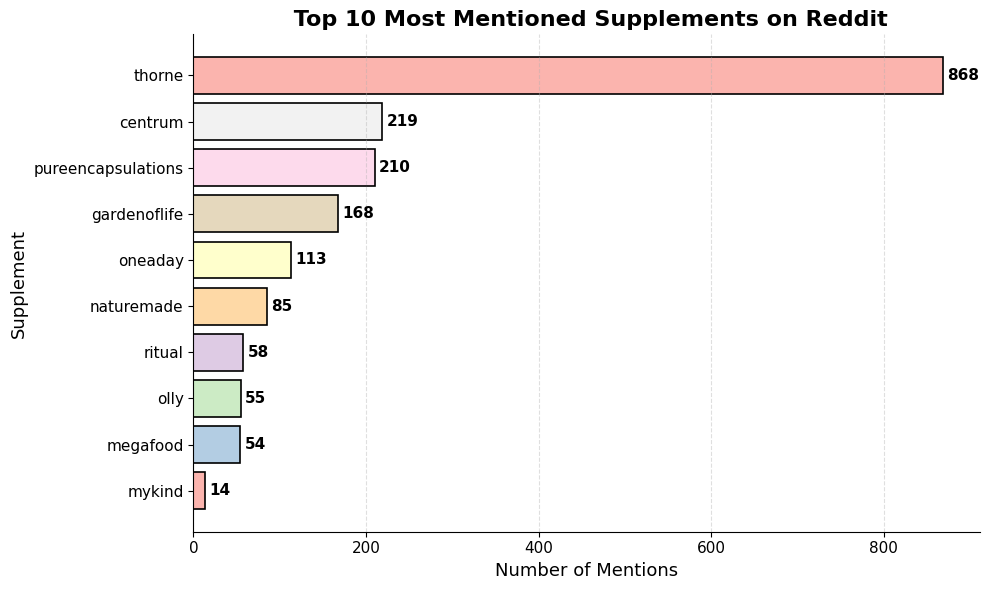

In [48]:

# Get top 10 supplements 
top_supplements = dict(supplement_counts.most_common(10))

supplements = list(top_supplements.keys())[::-1]
counts = list(top_supplements.values())[::-1]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(supplements, counts, color=plt.cm.Pastel1.colors[:10], edgecolor='black', linewidth=1.2)

# Title & labels
plt.title(" Top 10 Most Mentioned Supplements on Reddit", fontsize=16, fontweight='bold')
plt.xlabel("Number of Mentions", fontsize=13)
plt.ylabel("Supplement", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Remove spines
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add values at the end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, str(width),
             ha='left', va='center', fontsize=11, fontweight='bold')

# Layout
plt.tight_layout()
plt.show()


In [49]:
## Get unique titles

df_unique_titles = df[['Title_raw', 'lemmas_title']].drop_duplicates(subset='Title_raw')


In [50]:
df_unique_titles['mentioned_supplements_title'] = df_unique_titles['lemmas_title'].apply(
    lambda tokens: [s for s in supplement_whitelist if s in tokens]
)


In [51]:
from collections import Counter

all_mentions_unique = df_unique_titles['mentioned_supplements_title'].explode()
supplement_counts_unique = Counter(all_mentions_unique)

supplement_counts_unique.most_common(10)


[('thorne', 74),
 ('gardenoflife', 53),
 ('pureencapsulations', 34),
 ('olly', 33),
 ('centrum', 32),
 ('ritual', 13),
 ('oneaday', 12),
 ('naturemade', 10),
 ('megafood', 6),
 ('weightworld', 4)]

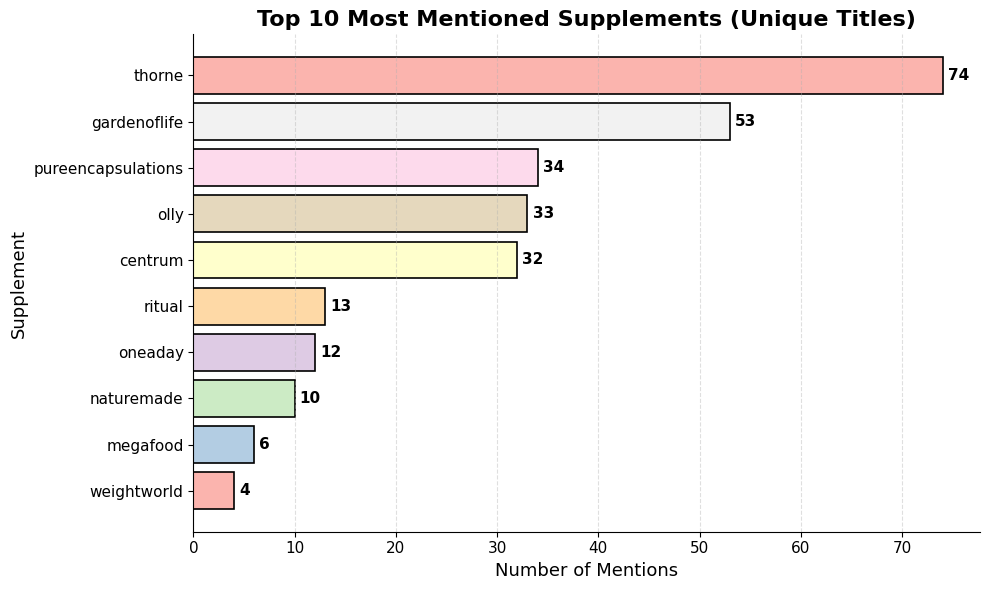

In [52]:

# Use the corrected unique counts
top_supplements = dict(supplement_counts_unique.most_common(10))  # <<< change this line

# Reverse for better top-to-bottom display
supplements = list(top_supplements.keys())[::-1]
counts = list(top_supplements.values())[::-1]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(supplements, counts, color=plt.cm.Pastel1.colors[:10], edgecolor='black', linewidth=1.2)

# Title & labels
plt.title("Top 10 Most Mentioned Supplements (Unique Titles)", fontsize=16, fontweight='bold')
plt.xlabel("Number of Mentions", fontsize=13)
plt.ylabel("Supplement", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Remove spines
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add values at the end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, str(width),
             ha='left', va='center', fontsize=11, fontweight='bold')

# Layout
plt.tight_layout()
plt.show()


#### Set Up VADER Sentiment Analyzer
VADER is a lexicon- and rule-based sentiment analysis tool well-suited for social media and informal text.  
Here, we import and initialize the SentimentIntensityAnalyzer after downloading the required lexicon.


In [53]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Miali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [54]:
# Define a function to get VADER sentiment scores
def get_vader_sentiment(text):
    scores = sia.polarity_scores(text)
    return scores


In [55]:
# Apply to Comment_raw
df['vader_scores'] = df['Comment_raw'].apply(get_vader_sentiment)

In [56]:
# Expand VADER scores into separate columns
df['vader_neg'] = df['vader_scores'].apply(lambda x: x['neg'])
df['vader_neu'] = df['vader_scores'].apply(lambda x: x['neu'])
df['vader_pos'] = df['vader_scores'].apply(lambda x: x['pos'])
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])


In [57]:
# Define classification based on compound score
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply it to your DataFrame
df['vader_sentiment_label'] = df['vader_compound'].apply(classify_sentiment)


#### Visualize Sentiment Distribution (VADER)
This bar chart shows the number of Reddit comments classified into **Positive**, **Neutral**, and **Negative** sentiment categories using VADER:


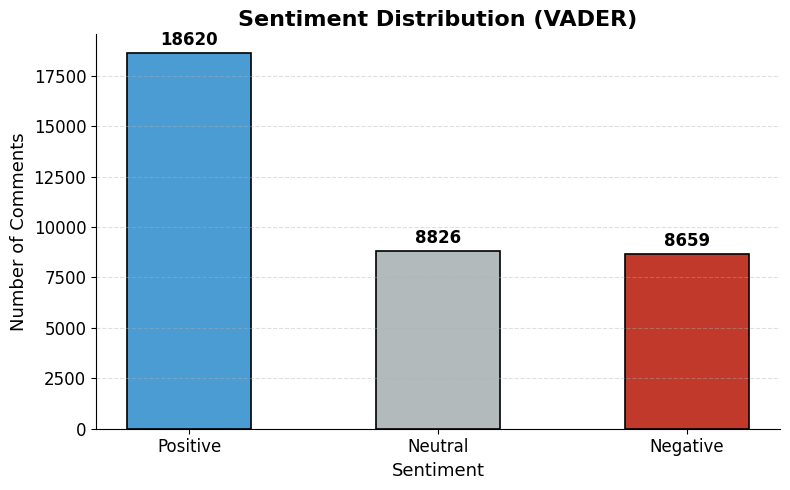

In [ ]:
# Count sentiment labels
sentiment_counts = df['vader_sentiment_label'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, 
               color=['#4B9CD3', '#B2BABB', '#C0392B'],  
               edgecolor='black', linewidth=1.2, width=0.5)

# Title and labels
plt.title('Sentiment Distribution (VADER)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Comments', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add horizontal gridlines
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Remove top and right border
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 200, str(height),
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()



In [67]:
# Explode comments with multiple supplements into separate rows
df_exploded = df.explode('mentioned_supplements')


In [68]:
# Create sentiment distribution (normalized) per supplement
sentiment_by_supplement = (
    df_exploded
    .groupby('mentioned_supplements')['vader_sentiment_label']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)


In [69]:
# Top 10 most frequently mentioned supplements
top_supplements = (
    df_exploded['mentioned_supplements']
    .value_counts()
    .head(10)
    .index
)

# Filter the sentiment data to just those top supplements
sentiment_top = sentiment_by_supplement.loc[top_supplements]


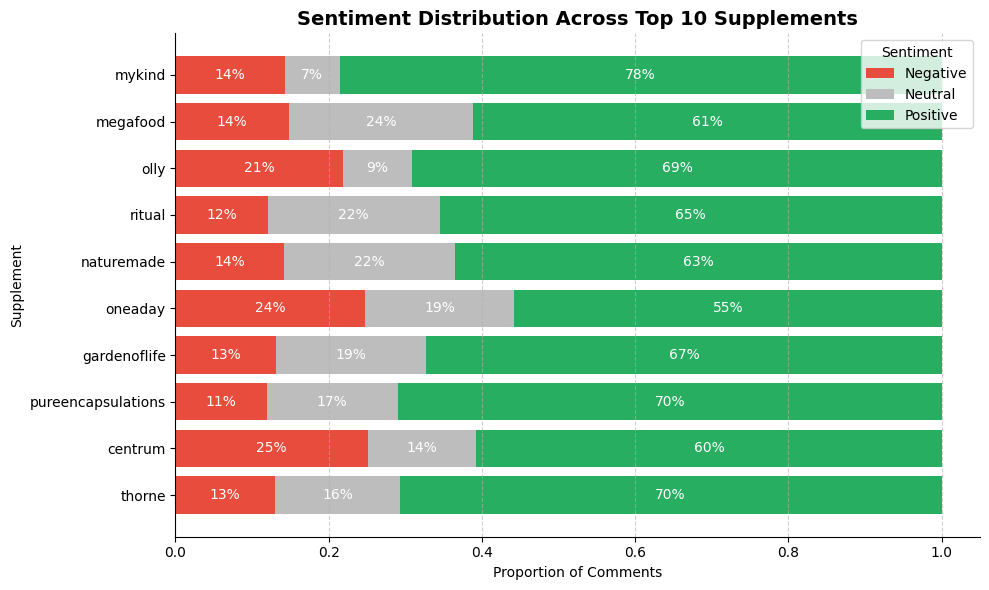

In [72]:
#### Visualize Sentiment Distribution for Top 10 Mentioned Supplements
# Define color scheme
colors = {'Negative': '#E74C3C', 'Neutral': '#BDBDBD', 'Positive': '#27AE60'}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(sentiment_top))

for sentiment in ['Negative', 'Neutral', 'Positive']:
    values = sentiment_top[sentiment].values
    bars = ax.barh(sentiment_top.index, values, left=bottom,
                   label=sentiment, color=colors[sentiment])
    
    # Add percentage text
    for i, (v, b) in enumerate(zip(values, bottom)):
        if v > 0.05:  # avoid cluttering with tiny labels
            ax.text(b + v/2, i, f'{int(v*100)}%', va='center', ha='center', color='white', fontsize=10)
    
    bottom += values

# Labels & formatting
ax.set_title('Sentiment Distribution Across Top 10 Supplements', fontsize=14, fontweight='bold')
ax.set_xlabel('Proportion of Comments')
ax.set_ylabel('Supplement')
ax.legend(title='Sentiment')
ax.grid(axis='x', linestyle='--', alpha=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


#### Load Reddit Dataset with RoBERTa Sentiment Results
The RoBERTa-based sentiment analysis was performed separately and saved to a new file.  
This CSV (`reddit_with_roberta_sentiment.csv`) contains the original Reddit comments along with the added RoBERTa sentiment scores and labels.


In [74]:
# Load the updated Reddit multivitamin dataset with RoBERTa
df = pd.read_csv("reddit_with_roberta_sentiment.csv")

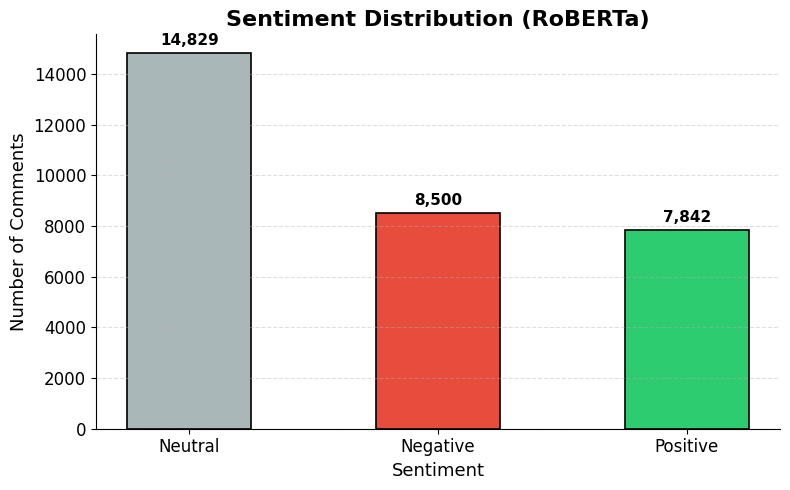

In [75]:
# Count RoBERTa sentiment labels
roberta_sentiment_counts = df['roberta_sentiment'].value_counts()

# Custom colors: Neutral (gray), Negative (red), Positive (green)
colors = ['#AAB7B8', '#E74C3C', '#2ECC71']  # Neutral, Negative, Positive
order = ['Neutral', 'Negative', 'Positive']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(order, [roberta_sentiment_counts.get(x, 0) for x in order],
               color=colors, edgecolor='black', linewidth=1.2, width=0.5)

# Title and labels
plt.title('Sentiment Distribution (RoBERTa)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Comments', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 200, f'{height:,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Style tweaks
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



In [77]:
## Re-run VADER

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Apply VADER on Comment_raw
df['vader_scores'] = df['Comment_raw'].apply(sia.polarity_scores)

# Expand scores into separate columns
df['vader_neg'] = df['vader_scores'].apply(lambda x: x['neg'])
df['vader_neu'] = df['vader_scores'].apply(lambda x: x['neu'])
df['vader_pos'] = df['vader_scores'].apply(lambda x: x['pos'])
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])

# Create simple VADER sentiment label
def classify_vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment_label'] = df['vader_compound'].apply(classify_vader_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Miali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


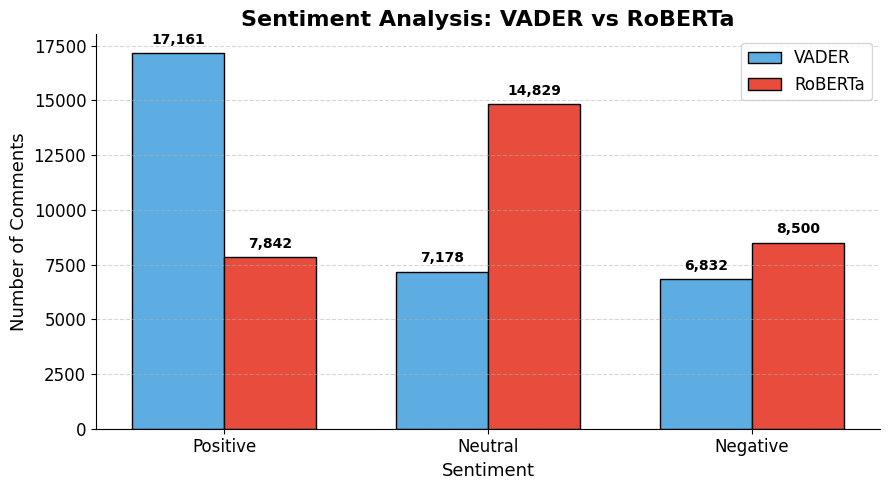

In [79]:
## Plot comparision

# Define the order of sentiment labels
labels = ['Positive', 'Neutral', 'Negative']

# Get sentiment counts from the DataFrame
vader_counts = df['vader_sentiment_label'].value_counts()
roberta_counts = df['roberta_sentiment'].value_counts()

# Align counts with defined label order
vader_values = [vader_counts.get(label, 0) for label in labels]
roberta_values = [roberta_counts.get(label, 0) for label in labels]

# Bar positions and width
x = np.arange(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(9, 5))

bars1 = ax.bar(x - width/2, vader_values, width, label='VADER', color='#5DADE2', edgecolor='black')
bars2 = ax.bar(x + width/2, roberta_values, width, label='RoBERTa', color='#E74C3C', edgecolor='black')

# Title and labels
ax.set_title('Sentiment Analysis: VADER vs RoBERTa', fontsize=16, fontweight='bold')
ax.set_xlabel('Sentiment', fontsize=13)
ax.set_ylabel('Number of Comments', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 300, f'{height:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Legend
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


### Sentiment Distribution Across Top 10 Supplements (RoBERTa)

In [82]:

def extract_supplements(text, whitelist):
    found = [supp for supp in whitelist if supp in text.lower()]
    return found if found else np.nan

df['mentioned_supplements'] = df['Comment_raw'].apply(lambda x: extract_supplements(str(x), supplement_whitelist))


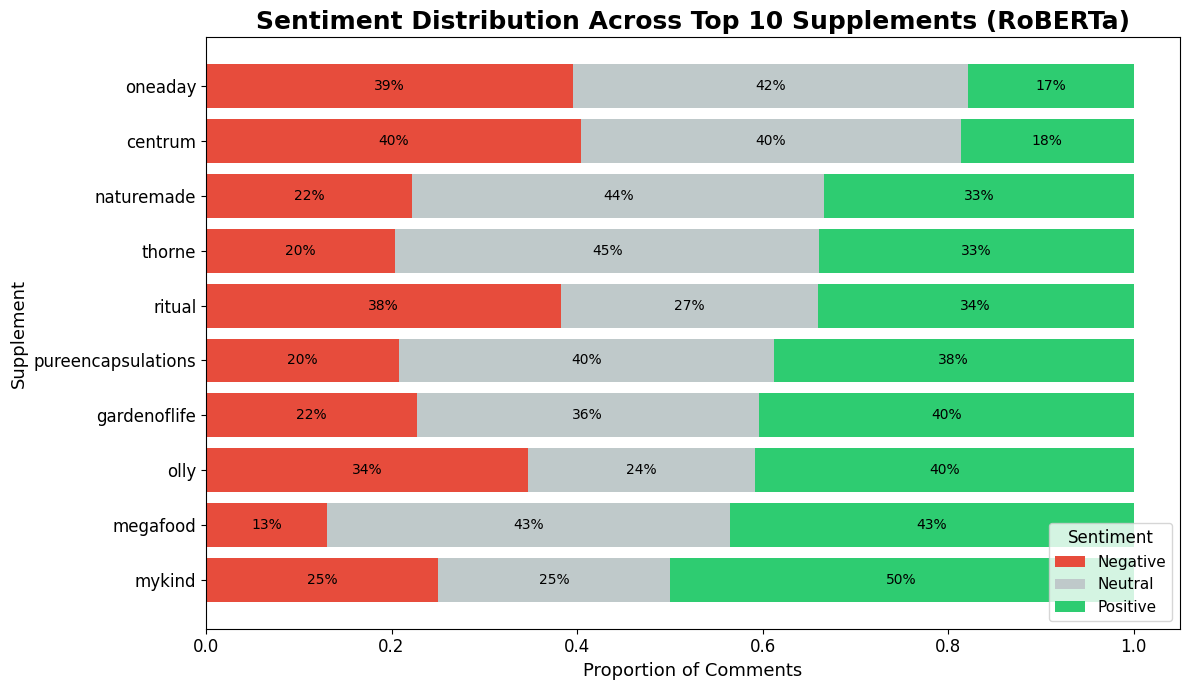

In [83]:

## Group by supplement and sentiment
df_exploded_roberta = df.explode('mentioned_supplements')
sentiment_by_supp = df_exploded_roberta.groupby('mentioned_supplements')['roberta_sentiment'].value_counts(normalize=True).unstack(fill_value=0)

# Select top 10 supplements by total mentions
top10 = df_exploded_roberta['mentioned_supplements'].value_counts().head(10).index
sentiment_by_supp = sentiment_by_supp.loc[top10]

# Optional: sort by positive sentiment
sentiment_by_supp = sentiment_by_supp.sort_values(by='Positive', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

colors = {
    'Negative': '#E74C3C',
    'Neutral': '#BFC9CA',
    'Positive': '#2ECC71'
}

bottoms = [0] * len(sentiment_by_supp)
for sentiment in ['Negative', 'Neutral', 'Positive']:
    values = sentiment_by_supp[sentiment]
    ax.barh(sentiment_by_supp.index, values, left=bottoms, 
            label=sentiment, color=colors[sentiment])
    for i, (value, bottom) in enumerate(zip(values, bottoms)):
        ax.text(bottom + value/2, i, f'{int(value*100)}%', va='center', ha='center', fontsize=10, color='black')
    bottoms = [sum(x) for x in zip(bottoms, values)]

# Labels and title
ax.set_title("Sentiment Distribution Across Top 10 Supplements (RoBERTa)", fontsize=18, fontweight='bold')
ax.set_xlabel("Proportion of Comments", fontsize=13)
ax.set_ylabel("Supplement", fontsize=13)
ax.tick_params(axis='both', labelsize=12)

# Legend
ax.legend(title="Sentiment", fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()




In [96]:
# Filter comments where VADER says Positive but RoBERTa says Neutral
conflicting_comments = df[
    (df['vader_sentiment_label'] == 'Positive') &
    (df['roberta_sentiment'] == 'Neutral')
]


In [98]:
# Randomly sample 5 such cases
conflicting_comments[['Comment_raw', 'vader_sentiment_label', 'roberta_sentiment']].sample(5, random_state=42)


,Comment_raw,vader_sentiment_label,roberta_sentiment
24322,"pescetarian and vegan eating patterns enjoy similar health outcomes, according to the available body of research. \n\nwhile the so-called blue zones are an interesting starting point for inquiry into what makes people live long, there are some de...",Positive,Neutral
21192,isn't everyone in monaco also super wealthy?,Positive,Neutral
18720,there are certainly other sources of fiber and the added sugar content i've seen is from 0-15% in high-quality concentrates.,Positive,Neutral
6933,what’s a good mg for metafolin? is that the same as 5-mthf?,Positive,Neutral
15494,zma for muscle recovery/sleep. magnesium for energy.,Positive,Neutral


###  Interpretation: Most Discussed Supplements on Reddit

The horizontal bar chart highlights the top 10 most mentioned supplement brands across Reddit discussions related to wellness and multivitamins.

- **Thorne** stands out overwhelmingly, with **739 mentions**, far ahead of any other brand. This suggests it plays a major role in Reddit supplement conversations, possibly due to popularity, effectiveness, or controversy.

- **Centrum** and **Pure Encapsulations** follow, with **193** and **181** mentions respectively. These are established brands that cater to both general and clinical-use audiences.

- Brands like **Garden of Life**, **One A Day**, and **Nature Made** appear mid-range, well-known but not dominating Reddit chatter.

- **MyKind**, **Olly**, **Ritual**, and **Megafood** round out the list with lower but still notable presence, potentially appealing to niche communities or newer users.
